In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("/content/drive/MyDrive/car_price.csv", sep = ',', na_values='?')
df

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,633238,743850,5,125092,1,6,11,171,95,97,190744.0
996,997,599626,848195,4,83370,2,9,14,161,101,120,419748.0
997,998,646344,842733,7,86722,1,8,9,196,113,89,405871.0
998,999,535559,732439,2,140478,4,5,9,184,112,128,74398.0


In [ ]:
df = df.drop('v.id', axis=1)

In [ ]:
X = df.drop('current price', axis=1)
y = df['current price']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование обратно в DataFrame для удобства
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (800, 10)
Размер тестовой выборки: (200, 10)


In [ ]:
# Определение параметров для поиска по сетке
param_grid = {'alpha': np.logspace(-5, 2, 100)}

# Создание модели LASSO
lasso = Lasso()

In [ ]:
grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Оптимальное значение alpha: {grid.best_params_['alpha']}")

Оптимальное значение alpha: 84.97534359086438


In [ ]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']

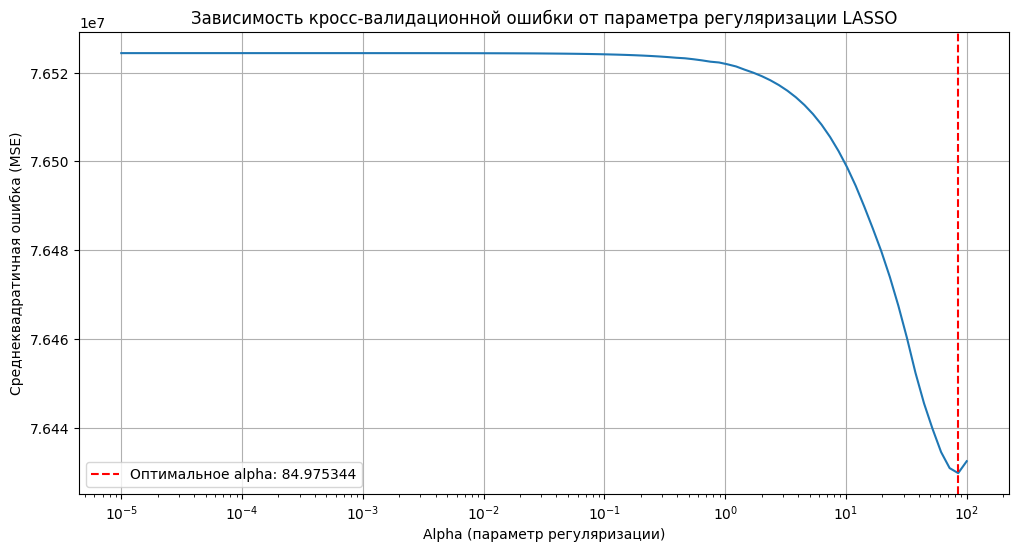

In [ ]:
plt.figure(figsize=(12, 6))
plt.semilogx(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.axvline(grid.best_params_['alpha'], color='r', linestyle='--', label=f'Оптимальное alpha: {grid.best_params_["alpha"]:.6f}')
plt.xlabel('Alpha (параметр регуляризации)')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.title('Зависимость кросс-валидационной ошибки от параметра регуляризации LASSO')
plt.legend()
plt.grid(True)
plt.show()

Метрики качества модели LASSO:
MSE: 80823231.99
RMSE: 8990.17
MAE: 7539.38
R²: 0.9952


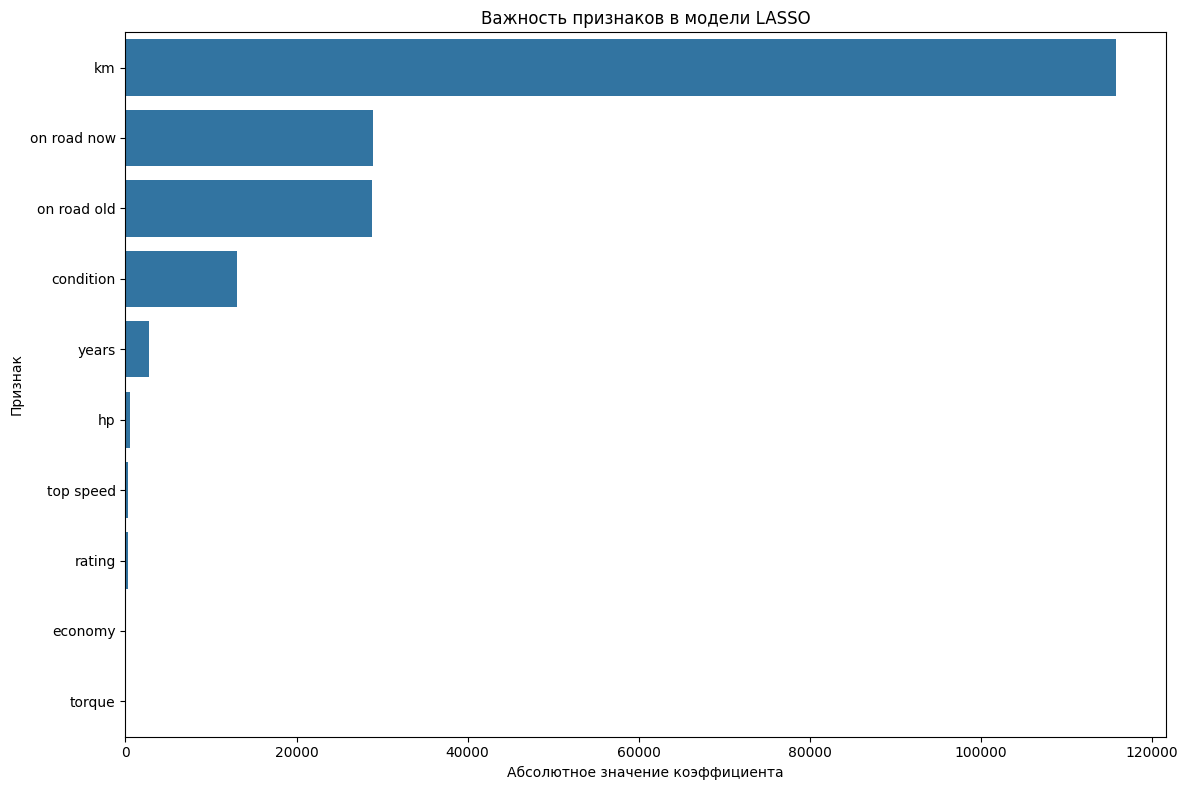

Количество отобранных признаков (ненулевых коэффициентов): 9 из 10


In [ ]:
# Обучение модели LASSO с оптимальным значением alpha
best_lasso = Lasso(alpha=grid.best_params_['alpha'])
best_lasso.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred_lasso = best_lasso.predict(X_test_scaled)

# Вычисление метрик качества
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Метрики качества модели LASSO:")
print(f"MSE: {mse_lasso:.2f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"MAE: {mae_lasso:.2f}")
print(f"R²: {r2_lasso:.4f}")

# Построение графика важности признаков
feature_importance = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': np.abs(best_lasso.coef_)
})
feature_importance = feature_importance.sort_values('Важность', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Признак', data=feature_importance)
plt.title('Важность признаков в модели LASSO')
plt.xlabel('Абсолютное значение коэффициента')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Вывод количества ненулевых коэффициентов (отобранных признаков)
nonzero_features = np.sum(best_lasso.coef_ != 0)
print(f"Количество отобранных признаков (ненулевых коэффициентов): {nonzero_features} из {X_train.shape[1]}")

Оптимальное количество признаков: 7


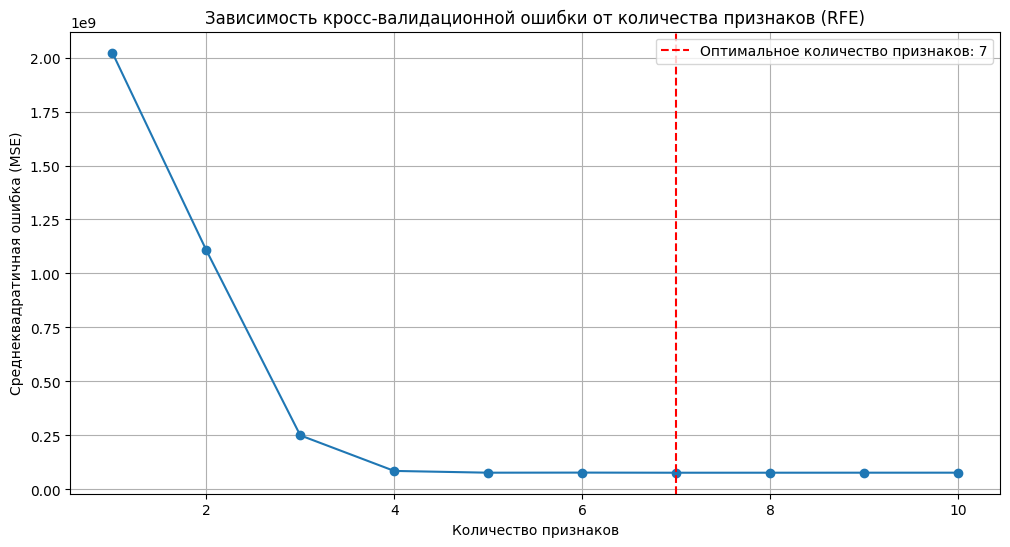

In [ ]:
# Создание модели линейной регрессии
lr = LinearRegression()

# Создание объекта RFECV для отбора признаков
rfecv = RFECV(estimator=lr, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

# Вывод оптимального количества признаков
print(f"Оптимальное количество признаков: {rfecv.n_features_}")

# Получение результатов кросс-валидации
cv_scores = -rfecv.cv_results_['mean_test_score']  # Преобразование обратно в MSE

# Построение графика кросс-валидационной ошибки в зависимости от числа признаков
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.axvline(rfecv.n_features_, color='r', linestyle='--', label=f'Оптимальное количество признаков: {rfecv.n_features_}')
plt.xlabel('Количество признаков')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.title('Зависимость кросс-валидационной ошибки от количества признаков (RFE)')
plt.legend()
plt.grid(True)
plt.show()

Отобранные признаки: ['on road old', 'on road now', 'years', 'km', 'condition', 'top speed', 'hp']
Метрики качества модели LinearRegression с RFE:
MSE: 81040133.96
RMSE: 9002.23
MAE: 7550.82
R²: 0.9952


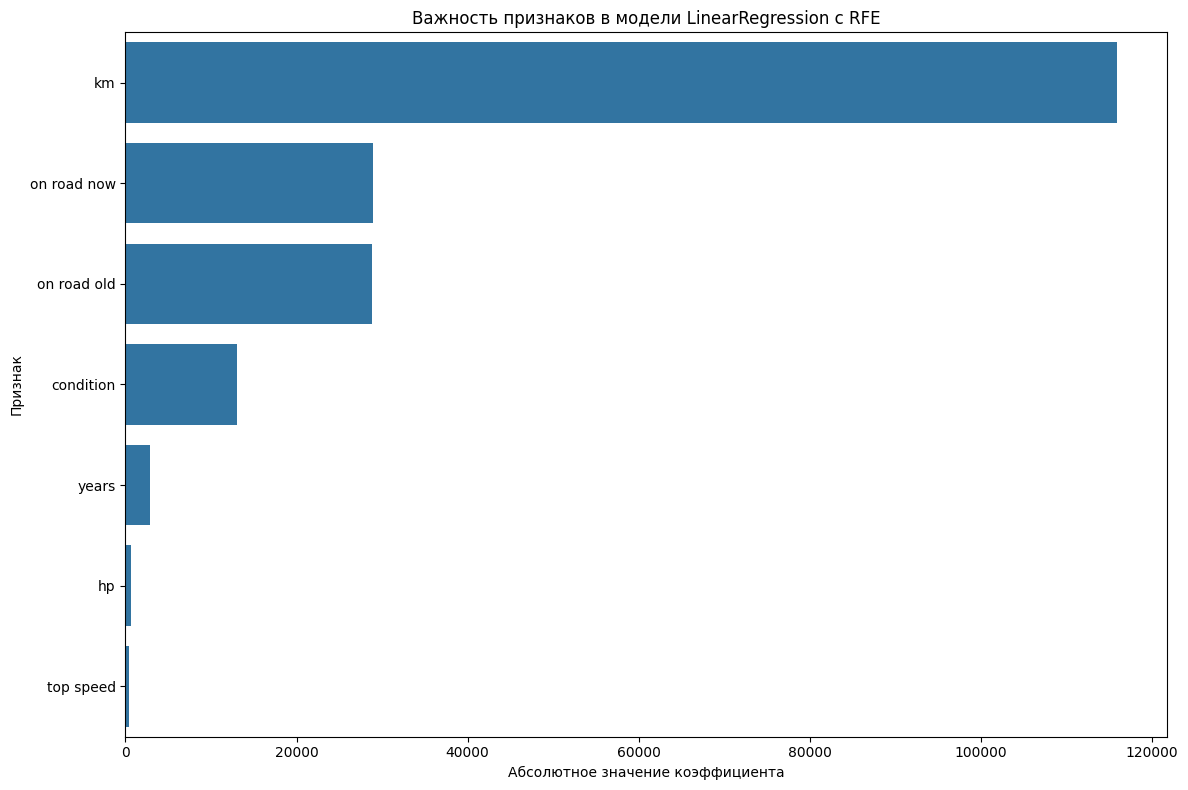

In [ ]:
# Получение отобранных признаков
selected_features = X_train.columns[rfecv.support_].tolist()
print(f"Отобранные признаки: {selected_features}")

# Обучение модели линейной регрессии на отобранных признаках
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]

lr_selected = LinearRegression()
lr_selected.fit(X_train_selected, y_train)

# Предсказание на тестовой выборке
y_pred_rfe = lr_selected.predict(X_test_selected)

# Вычисление метрик качества
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
rmse_rfe = np.sqrt(mse_rfe)
mae_rfe = mean_absolute_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f"Метрики качества модели LinearRegression с RFE:")
print(f"MSE: {mse_rfe:.2f}")
print(f"RMSE: {rmse_rfe:.2f}")
print(f"MAE: {mae_rfe:.2f}")
print(f"R²: {r2_rfe:.4f}")

# Построение графика важности признаков
feature_importance_rfe = pd.DataFrame({
    'Признак': selected_features,
    'Важность': np.abs(lr_selected.coef_)
})
feature_importance_rfe = feature_importance_rfe.sort_values('Важность', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Признак', data=feature_importance_rfe)
plt.title('Важность признаков в модели LinearRegression с RFE')
plt.xlabel('Абсолютное значение коэффициента')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()